# Gesture Recognition
In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly.

# <font color='orange'>Step1:Setup and import libraries</font>

In [ ]:
## Checking the GPU configuration

!nvidia-smi

Wed Sep 20 03:59:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install scikit-image

In [ ]:
#Import the necessary libraries
import numpy as np
import os
import datetime
import os
import warnings
from PIL import Image
warnings.filterwarnings("ignore")
import abc
from abc import ABCMeta
from sys import getsizeof
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.compat.v1.set_random_seed(30)
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Conv3D, MaxPooling3D , Conv2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D, Input
from keras.applications import mobilenet
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau ,EarlyStopping
from keras import optimizers
import cv2
import skimage.transform as transform
import skimage.io as io
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [ ]:
#Mount your google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Define project folder path
project_folder = "/content/gdrive/MyDrive/Project_data"

##  <font color='orange'>Step2:Generator</font>
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    #The generator function
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size

            for batch in range(num_batches):
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels

            remaining_seq=len(t)%batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels


    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):

        seq_len = remaining_seq if remaining_seq else batch_size
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        batch_labels = np.zeros((seq_len,self.num_classes))

        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        for folder in range(seq_len):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
                #Perform image reading and resizing
                image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=transform.resize(image,(self.image_height,self.image_width,3))

                #Normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]

                    image_resized=transform.resize(cropped,(self.image_height,self.image_width,3))
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        return(batch_data,batch_labels)

    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath ="/content/gdrive/MyDrive/"+ model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period =1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


    @abc.abstractmethod
    def define_model(self):
        pass

In [ ]:
#Plotting function
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

##  <font color='orange'>Step3:Model</font>

Here we make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

##  <font color='red'>Model1:Conv3D first model and testing Memory </font>

1.15 frames to be sampled\video

2.Batch size of 32

3.Images cropped to 120,120

4.128 dense neurons in the two dense layers

5.Epoch of 20

6.Dropout of 0.25

(360, 360, 3)


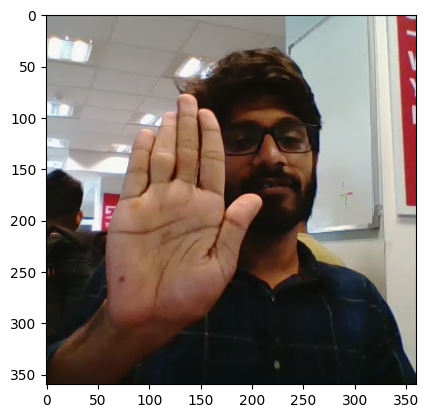

In [ ]:
##Sample image
image = io.imread('/content/gdrive/MyDrive/Project_data/train/WIN_20180907_15_48_01_Pro_Stop Gesture_new/WIN_20180907_15_48_01_Pro_00030.png')
print(image.shape)
plt.imshow(image/255)

In [ ]:
class Conv3D1(ModelBuilder):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv3D1 = Conv3D1()
conv3D1.initialize_path(project_folder)
conv3D1.initialize_image_properties(image_height=120,image_width=120)
conv3D1.initialize_hyperparams(frames_to_sample=15,batch_size=32,num_epochs=20)
conv3D1_model=conv3D1.define_model(dense_neurons=128,dropout=0.25)
conv3D1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 15, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 15, 120, 120, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 7, 60, 60, 16)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 32)     4

In [ ]:
history_model1=conv3D1.train_model(conv3D1_model)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.4533 - categorical_accuracy: 0.4872 
Epoch 1: val_loss improved from inf to 1.72222, saving model to model_init_2023-09-1614_58_08.114310/model-00001-1.45333-0.48718-1.72222-0.33000.h5
21/21 [==============================] - 1862s 93s/step - loss: 1.4533 - categorical_accuracy: 0.4872 - val_loss: 1.7222 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.7523 - categorical_accuracy: 0.7195
Epoch 2: val_loss did not improve from 1.72222
21/21 [==============================] - 92s 5s/step - loss: 0.7523 - categorical_accuracy: 0.7195 - val_loss: 2.7386 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.4508 - categorical_accuracy: 0.8281
Epoch 3: val_loss did not improve from 1.72222
21/21 [==============================] - 86s 4s/step - loss: 0.4508 - categorical_accuracy: 0.8281 - val

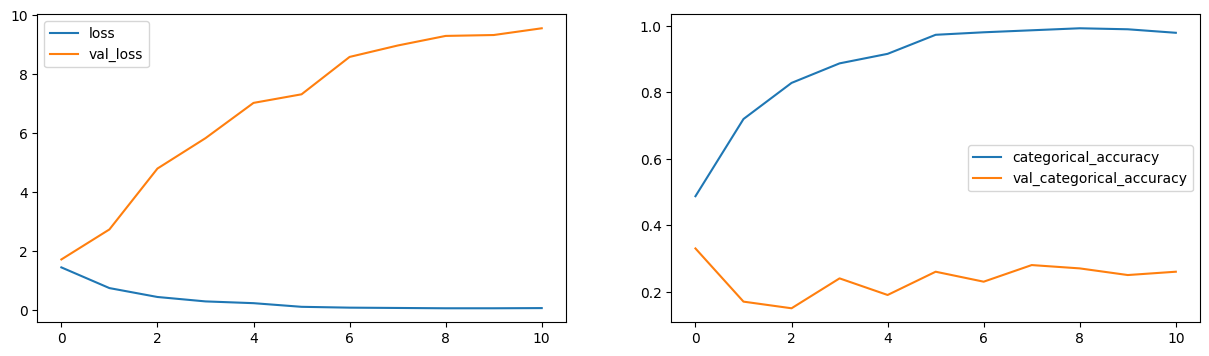

In [ ]:
# plot the model
plot(history_model1)

Get Memory utilization

In [ ]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((20,15,32,120,120)))/(1024*1024*1024)))

Memory util is 3.662109538912773 Gigs


#####  <font color='orange'>Observations and actions:</font>
1.Huge Overfitting.

2.Training set has accuracy of 0.97 whereas Validation set has accuracy only of 0.26 and Early stopping.

3.Let us increase the number of epochs and frames per video to handle this.

4.Let us also reduce the batch size so the model is able to generalize well.

##  <font color='red'>Model2:Conv3D model </font>
1.30 Epochs

2.Batch size of 20

3.20 frames to be sampled\video

4.Images cropped to 120,120

5.128 dense neurons in the two dense layers

6.Dropout of 0.25


In [ ]:
conv3D2 = Conv3D1()
conv3D2.initialize_path(project_folder)
conv3D2.initialize_image_properties(image_height=120,image_width=120)
conv3D2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv3D2_model=conv3D2.define_model(dense_neurons=128,dropout=0.25)
conv3D2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_4 (Activation)   (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_6 (Bat  (None, 20, 120, 120, 16   64        
 chNormalization)            )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 10, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)   

In [ ]:
history_model2=conv3D2.train_model(conv3D2_model)

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.4312 - categorical_accuracy: 0.4842  
Epoch 1: val_loss improved from inf to 2.23075, saving model to model_init_2023-09-1615_43_42.940072/model-00001-1.43124-0.48416-2.23075-0.19000.h5
34/34 [==============================] - 3147s 95s/step - loss: 1.4312 - categorical_accuracy: 0.4842 - val_loss: 2.2308 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 0.7752 - categorical_accuracy: 0.7029
Epoch 2: val_loss did not improve from 2.23075
34/34 [==============================] - 127s 4s/step - loss: 0.7752 - categorical_accuracy: 0.7029 - val_loss: 2.6442 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.5533 - categorical_accuracy: 0.7994
Epoch 3: val_loss did not improve from 2.23075
34/34 [==============================] - 120s 4s/step - loss: 0.5533 - categorical_accuracy: 0.7994 - 

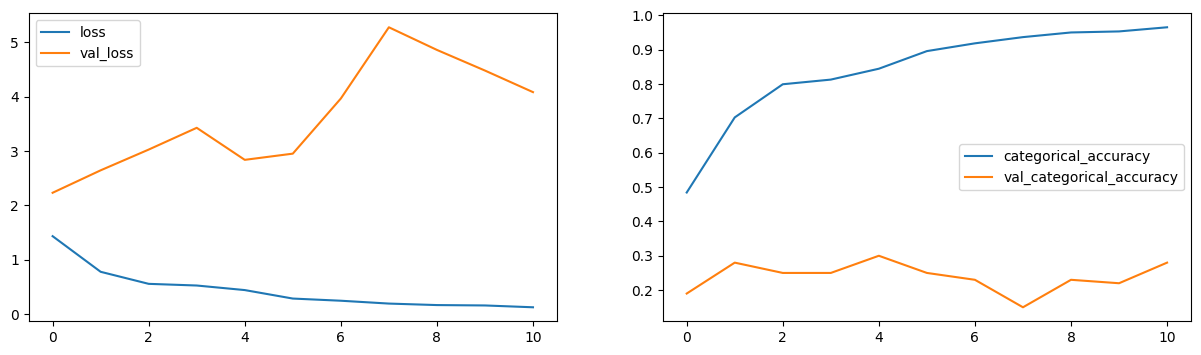

In [ ]:
# plot the model
plot(history_model2)

#####  <font color='orange'>Observations and actions:</font>

1.Validation accuracy improve only marginally.

2.We still have a lot of overfitting.

3.Validation set has terribale accuracy(0.28) whereas training set accuracy is 0.96.

4.We will decrease the batch size further so that it generalizes well.

5.We will further increase the dropout to handle overfitting.

##  <font color='red'>Model3:Conv3D model </font>

1.128 dense neurons in the two dense layers

2.Epochs = 30

3.Images cropped to 120,120

4.20 frames to be sampled\video

5.Batch size of 16 (perviously 20)

6.Dropout = 0.5


In [ ]:
conv3D3 = Conv3D1()
conv3D3.initialize_path(project_folder)
conv3D3.initialize_image_properties(image_height=120,image_width=120)
conv3D3.initialize_hyperparams(frames_to_sample=20,batch_size=16,num_epochs=30)
conv3D3_model=conv3D3.define_model(dense_neurons=128,dropout=0.5)
conv3D3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 20, 120, 120, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 10, 60, 60, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 32)    4

In [ ]:
history_model3=conv3D3.train_model(conv3D3_model)

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.8460 - categorical_accuracy: 0.3997  
Epoch 1: val_loss improved from inf to 3.86544, saving model to model_init_2023-09-1706_12_53.927939/model-00001-1.84597-0.39970-3.86544-0.18000.h5
42/42 [==============================] - 3899s 95s/step - loss: 1.8460 - categorical_accuracy: 0.3997 - val_loss: 3.8654 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.3416 - categorical_accuracy: 0.5339
Epoch 2: val_loss did not improve from 3.86544
42/42 [==============================] - 133s 3s/step - loss: 1.3416 - categorical_accuracy: 0.5339 - val_loss: 5.8089 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.1509 - categorical_accuracy: 0.5852
Epoch 3: val_loss did not improve from 3.86544
42/42 [==============================] - 127s 3s/step - loss: 1.1509 - categorical_accuracy: 0.5852 - 

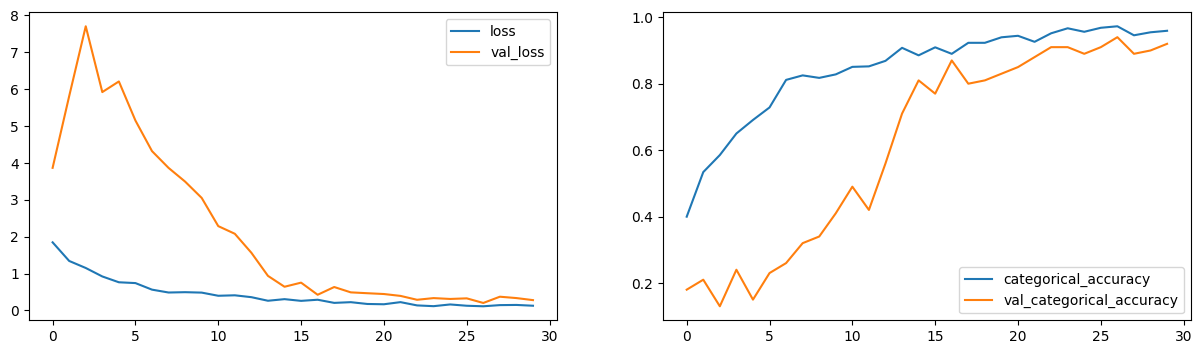

In [ ]:
# plot the model
plot(history_model3)

#####  <font color='orange'>Observations and actions:</font>

1.We have solved the overfitting problem(Epoch 30 had accuracy in training set as 95% whereas validation set had accuracy of 92%)

2.Epoch 27 was the best epoch with accuracy in training set as 97% and validation set as 94%.

3.As shown in the graph above, from Epoch15 the training and validation set loss and accuracy are comparable

4.The total number of parameters in the model is 1155397.

5.Validation loss is 0.20 in 27th Epoch and 0.27 in 30th Epoch.

5.Overfitting completely handled and we got good and consistent result after Epoch 15, hence we would stop with this conv3D model and move to GRU and Transfer Learning.


##  <font color='red'>Model4:CNN with GRU and Mobilenet(Transfer Learning)</font>

1.We will make use of CNN with GRU since GRU has less number of parameters compared to LSTM. We will also like to avail the benefits of Transfer Learning from Mobilenet(which is lightweight) to improve the model performance.

2.128 GRU  cells

3.Images cropped to 120 ,120 since it is working for us.

4.20 frames\video to be sampled

5.Batch size of 8 since it is large network.

6.Epoch of 25

7.Dropout of 0.5 since it worked well for us in previous experiment also.

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class GRU_with_Transfer(ModelBuilder):

    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        for layer in model.layers:
            layer.trainable = False
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
gru_transfer4 = GRU_with_Transfer()
gru_transfer4.initialize_path(project_folder)
gru_transfer4.initialize_image_properties(image_height=120,image_width=120)
gru_transfer4.initialize_hyperparams(frames_to_sample=20,batch_size=8,num_epochs=25)
gru_transfer4_model=gru_transfer4.define_model(gru_cells=128,dense_neurons=128,dropout=0.5)
gru_transfer4_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 3, 3, 1024)    3228864   
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 1024)          0         
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 128)               4

In [ ]:
history_model4=gru_transfer4.train_model(gru_transfer4_model)

Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.8066 - categorical_accuracy: 0.2926  
Epoch 1: val_loss improved from inf to 1.29646, saving model to model_init_2023-09-1804_04_08.685462/model-00001-1.80656-0.29261-1.29646-0.51000.h5
83/83 [==============================] - 10929s 133s/step - loss: 1.8066 - categorical_accuracy: 0.2926 - val_loss: 1.2965 - val_categorical_accuracy: 0.5100 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.2459 - categorical_accuracy: 0.5053
Epoch 2: val_loss improved from 1.29646 to 0.85550, saving model to model_init_2023-09-1804_04_08.685462/model-00002-1.24593-0.50528-0.85550-0.67000.h5
83/83 [==============================] - 125s 2s/step - loss: 1.2459 - categorical_accuracy: 0.5053 - val_loss: 0.8555 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 0.9885 - categorical_accuracy: 0.6214
Epoch 3: val_loss improved from 0.85550 to

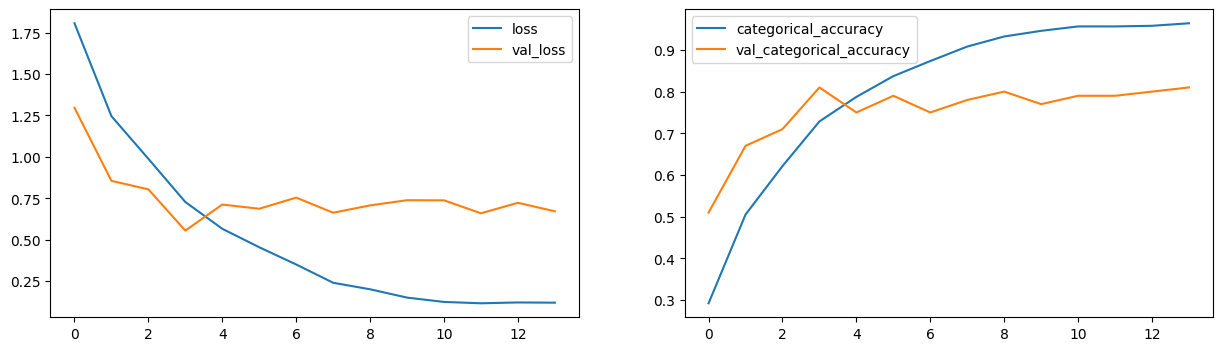

In [ ]:
# plot the model
plot(history_model4)

#####  <font color='orange'>Observations and actions:</font>

1.We encountered Early stopping at Epoch 14 as the Validation loss was not improving.

2.Epoch 14th had accuracy in training set as 96% and validation set as 81%.

3.As shown in the graph above,there is some overfitting.

4.The total number of parameters in the model is 3693253.

5.Best validation loss is 0.55 in 4th Epoch and 0.67 in 14th Epoch.

5.The results are not great so let us try another model with GRU+ MobileNet on all layers.


##  <font color='red'>Model5:CNN with GRU and Mobilenet(all layers)</font>

1.We will make use of CNN with GRU and Mobilenet on all layers to increase our accuracy.

2.128 GRU  cells.

3.Images cropped to 120 ,120 since it is working for us.

4.15 frames to be sampled.

5.Batch size of 8 since it is large network.

6.Epoch of 25.

7.Dropout of 0.25 since the previous model has not learnt very well.

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class GRU_with_Transfer_all(ModelBuilder):

    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        for layer in model.layers:
            layer.trainable = True
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
gru_transfer5 = GRU_with_Transfer_all()
gru_transfer5.initialize_path(project_folder)
gru_transfer5.initialize_image_properties(image_height=120,image_width=120)
gru_transfer5.initialize_hyperparams(frames_to_sample=15,batch_size=8,num_epochs=25)
gru_transfer5_model=gru_transfer5.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
gru_transfer5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 15, 3, 3, 1024)    3228864   
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 15, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 15, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 15, 1024)          0         
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 128)               4

In [ ]:
history_model5=gru_transfer5.train_model(gru_transfer5_model)

Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.0586 - categorical_accuracy: 0.5913 
Epoch 1: val_loss improved from inf to 0.66887, saving model to /content/gdrive/MyDrive/model_init_2023-09-1915_01_12.379587/model-00001-1.05856-0.59125-0.66887-0.75000.h5
83/83 [==============================] - 5680s 69s/step - loss: 1.0586 - categorical_accuracy: 0.5913 - val_loss: 0.6689 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 0.5378 - categorical_accuracy: 0.7798
Epoch 2: val_loss improved from 0.66887 to 0.37121, saving model to /content/gdrive/MyDrive/model_init_2023-09-1915_01_12.379587/model-00002-0.53778-0.77979-0.37121-0.80000.h5
83/83 [==============================] - 94s 1s/step - loss: 0.5378 - categorical_accuracy: 0.7798 - val_loss: 0.3712 - val_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 0.4046 - categorical_accuracy: 0.864

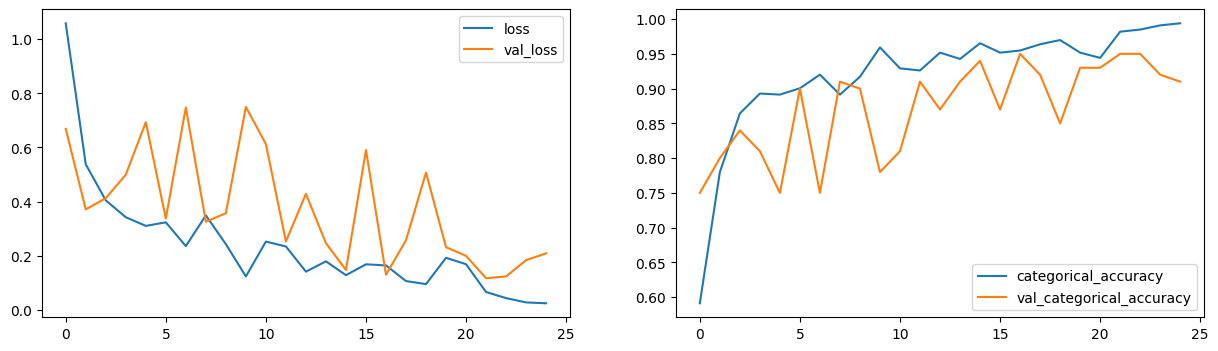

In [ ]:
# plot the model
plot(history_model5)

#####  <font color='orange'>Observations and conclusions:</font>

1.This is the best model in terms of validation accuracy and loss.

2.We achieved a validation accuracy of 0.95 in Epoch 22 and post that the validation loss did not decrease so no point in adding more epochs.

3.The validation loss was just 0.1171 in Epoch 22.

4.Training accuracy of 0.99 was achieved in best case.

5.The training and validation accuracy looks comparable with not much overfitting.

6.With this model we will conclude our experiments as we already got two good models and used GRU+Mobilnet on all layers.
